In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import simsopt
import simsopt.geo
import simsopt.field
import os
import copy
import sys

In [57]:
db_path = "QUASR_db/simsopt_serials/1114"
sopt_objs = []

# for ID in range(10000):
# fID = ID // 1000 
# sopt_objs.append(simsopt.load(f'./simsopt_serials/{fID:04}/serial{ID:07}.json'))

for filename in  os.listdir(db_path):
  sopt_objs.append(simsopt.load(os.path.join(db_path, filename)))

  # simsopt.geo.plot(np.concatenate(sopt_objs[-1]))

In [58]:
df = pd.DataFrame(sopt_objs, columns=["surfaces", "coils"])
df["lcfs"] = df["surfaces"].map(lambda x: x[-1])
df["AR"] = df["lcfs"].map(lambda x: x.aspect_ratio())
df["volume"] = df["lcfs"].map(lambda x: -x.volume())
df["nfp"] = df["lcfs"].map(lambda x: x.nfp)
df["R1"] = df["lcfs"].map(lambda x: x.minor_radius())

print(len(df))
df.head()

42


,surfaces,coils,lcfs,AR,volume,nfp,R1
0,[SurfaceXYZTensorFourier797],"[Coil5249, Coil5250, Coil5251, Coil5252, Coil5...",SurfaceXYZTensorFourier797,20.000039,0.049348,4,0.050000
1,"[SurfaceXYZTensorFourier798, SurfaceXYZTensorF...","[Coil5273, Coil5274, Coil5275, Coil5276, Coil5...",SurfaceXYZTensorFourier800,6.666820,0.444132,4,0.149999
2,"[SurfaceXYZTensorFourier801, SurfaceXYZTensorF...","[Coil5297, Coil5298, Coil5299, Coil5300, Coil5...",SurfaceXYZTensorFourier807,2.860970,2.418053,4,0.349844
3,"[SurfaceXYZTensorFourier808, SurfaceXYZTensorF...","[Coil5321, Coil5322, Coil5323, Coil5324, Coil5...",SurfaceXYZTensorFourier813,3.335870,1.776529,4,0.299924
4,[SurfaceXYZTensorFourier814],"[Coil5345, Coil5346, Coil5347, Coil5348, Coil5...",SurfaceXYZTensorFourier814,20.000015,0.049348,4,0.050000


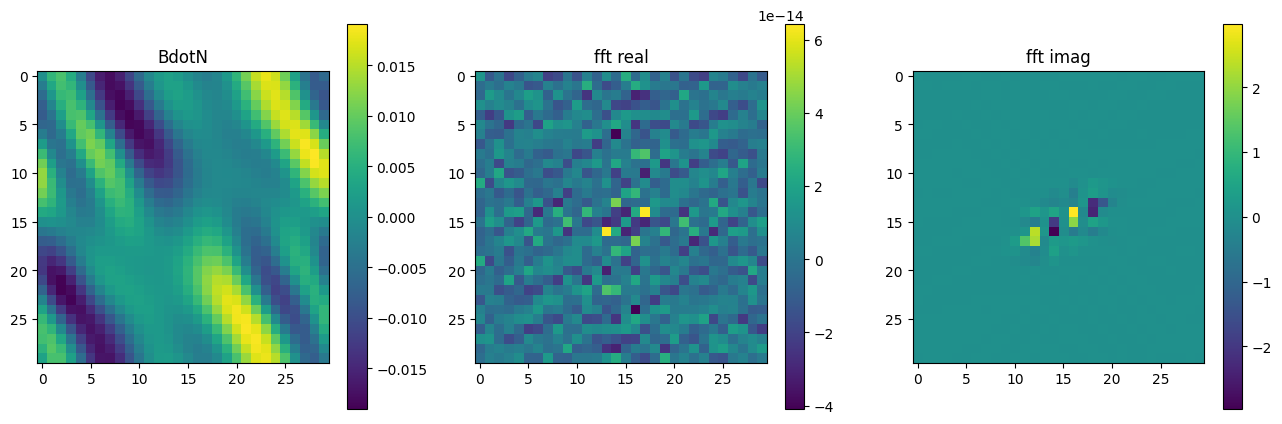

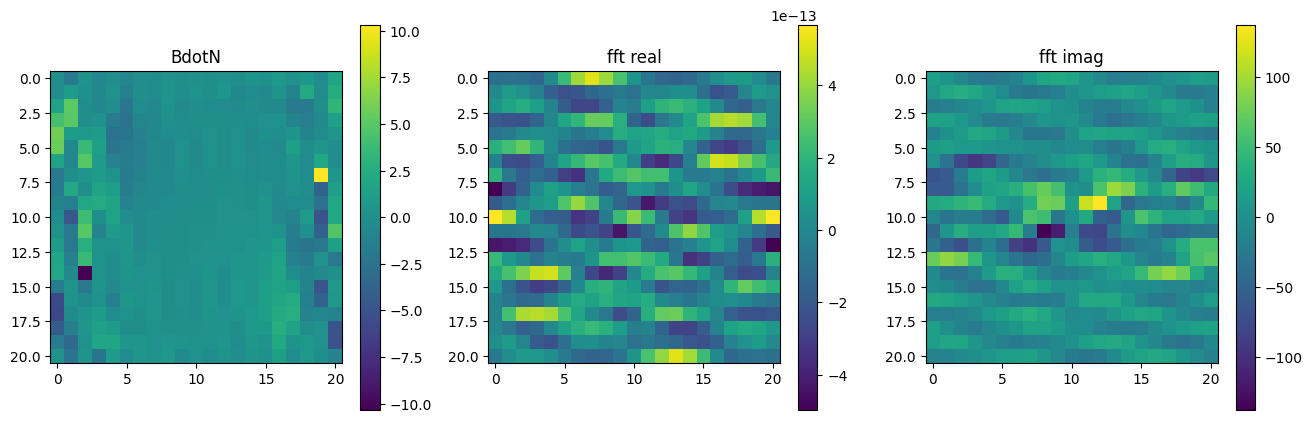

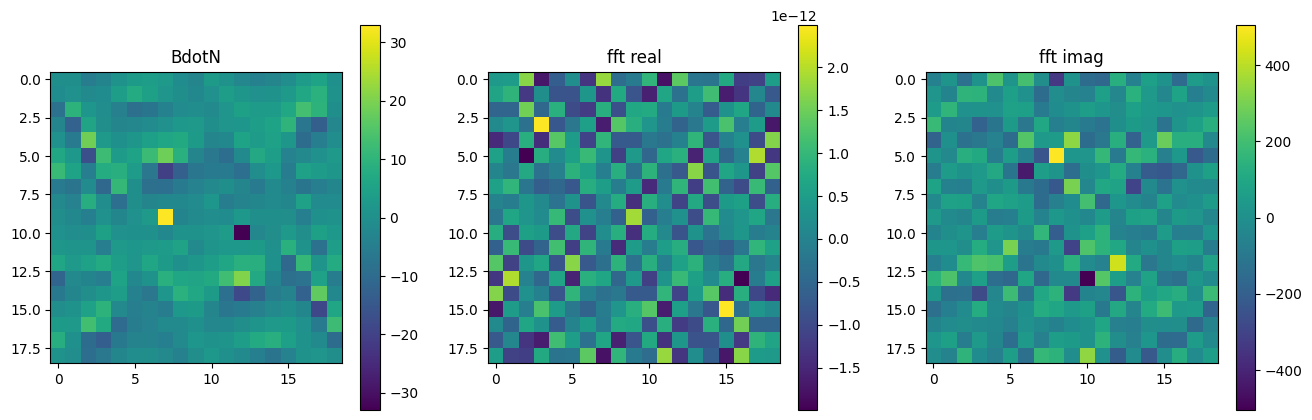

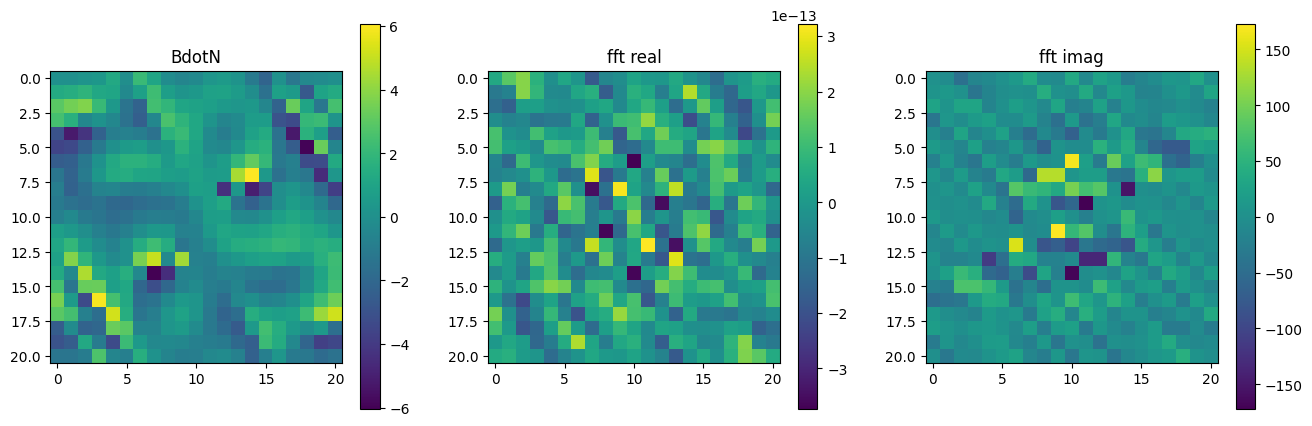

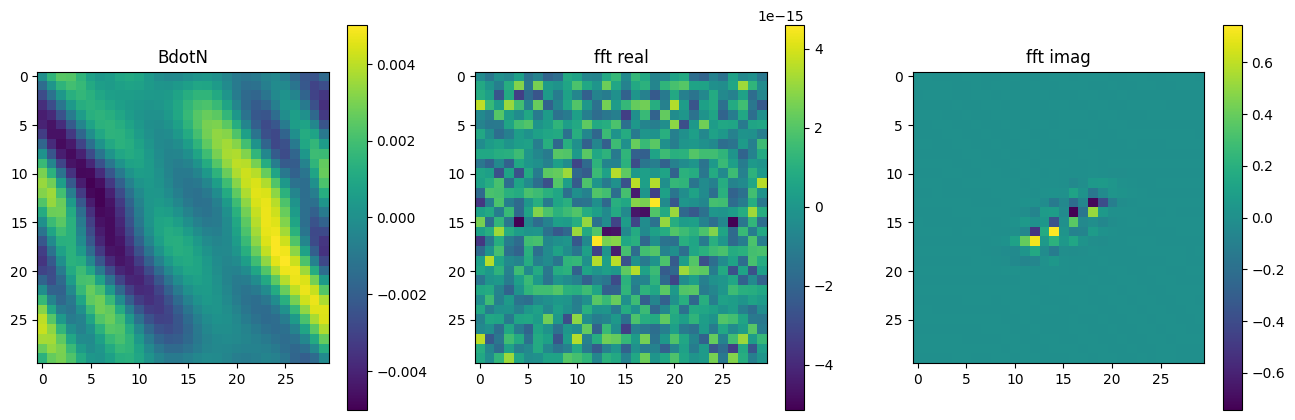

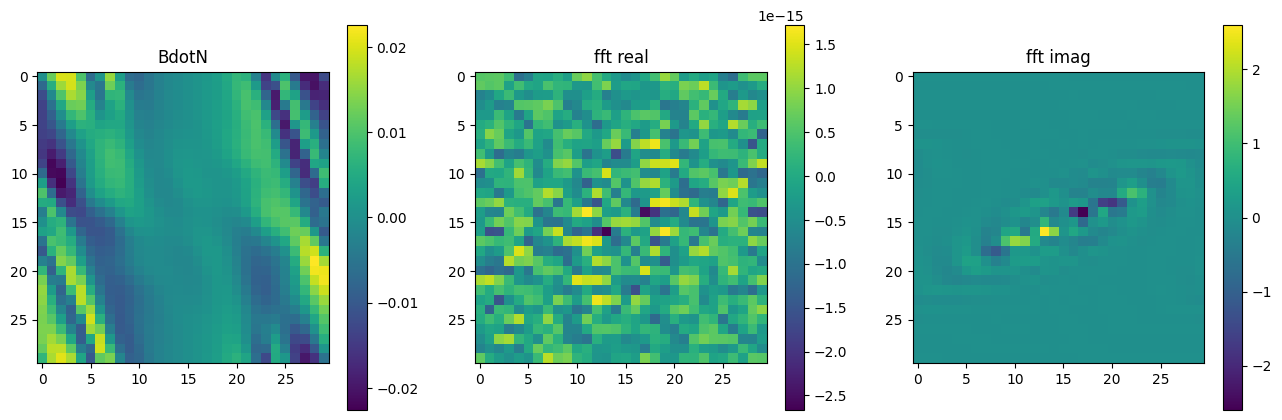

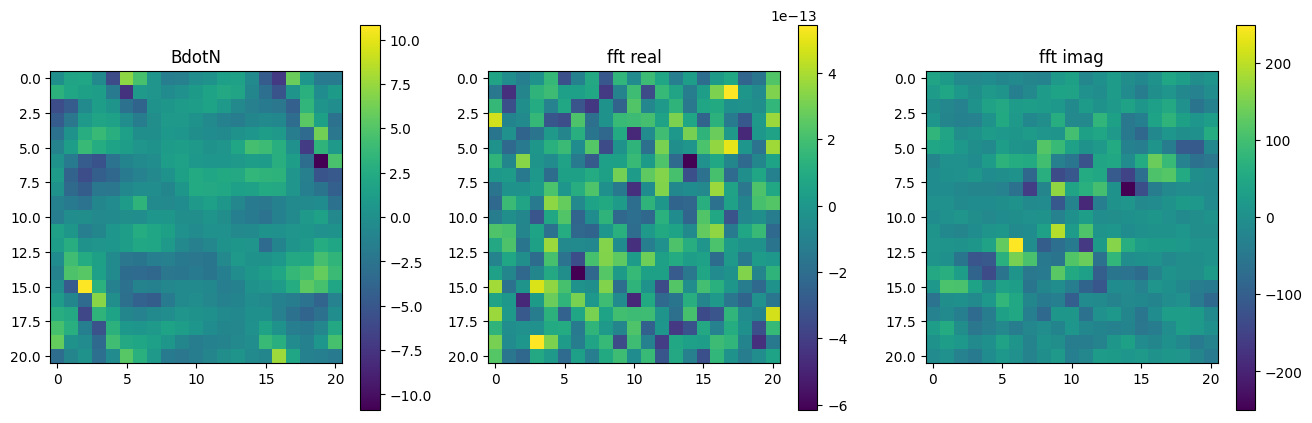

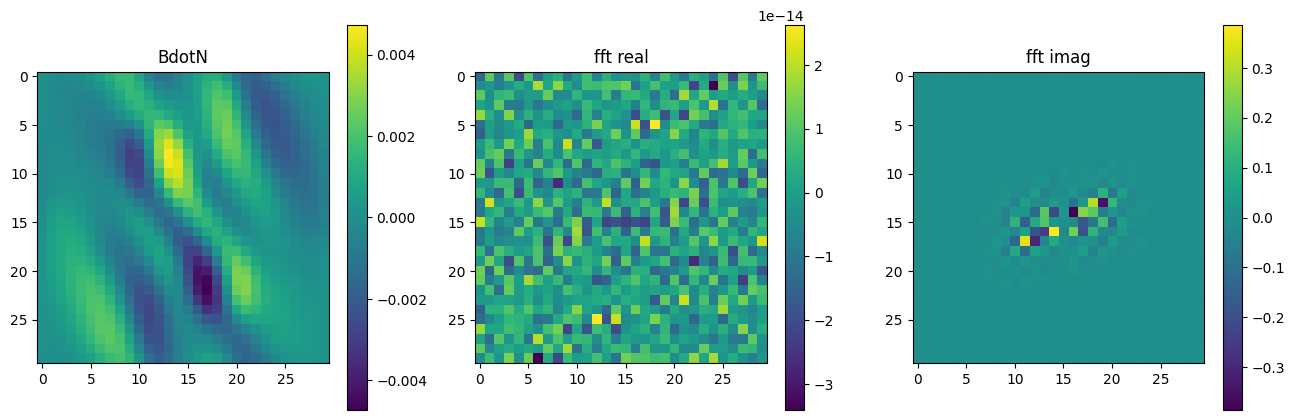

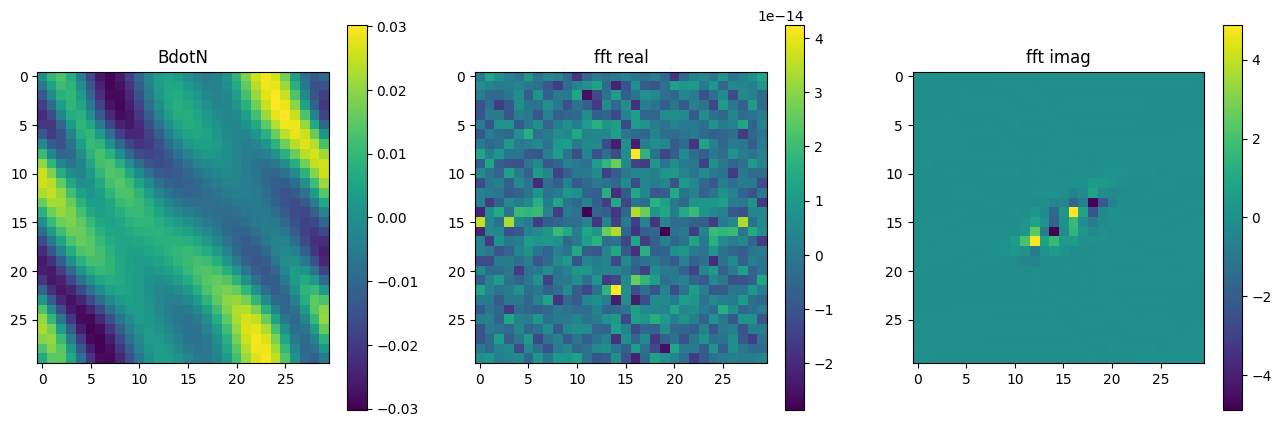

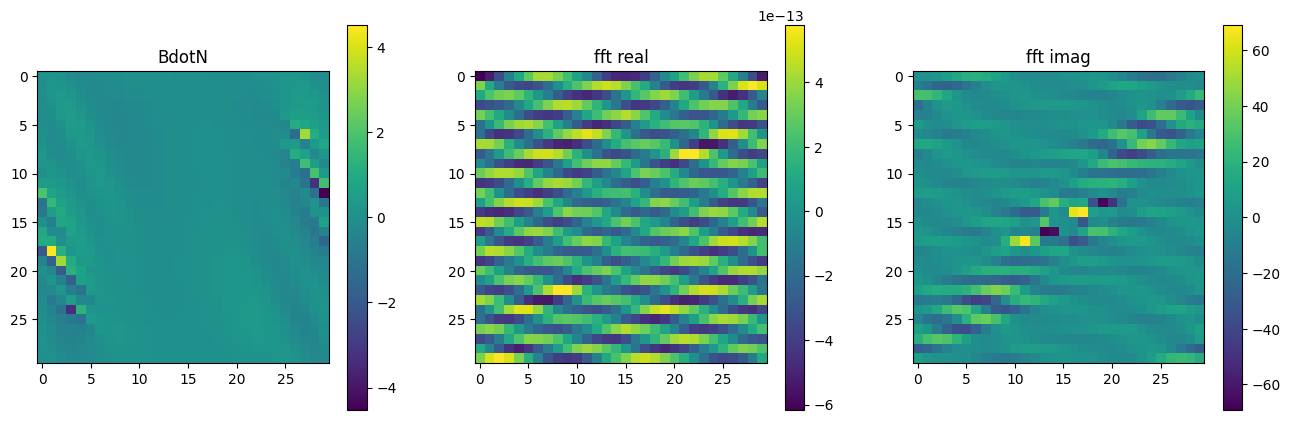

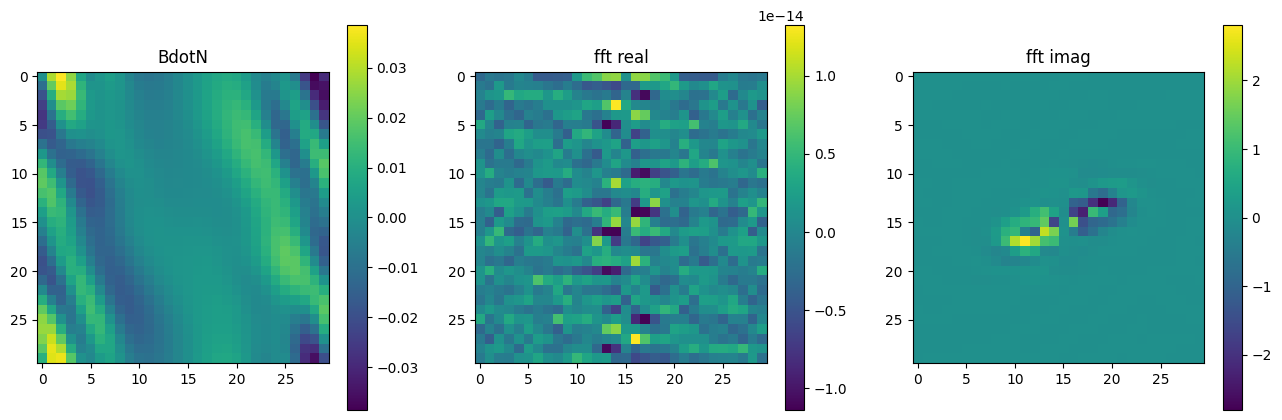

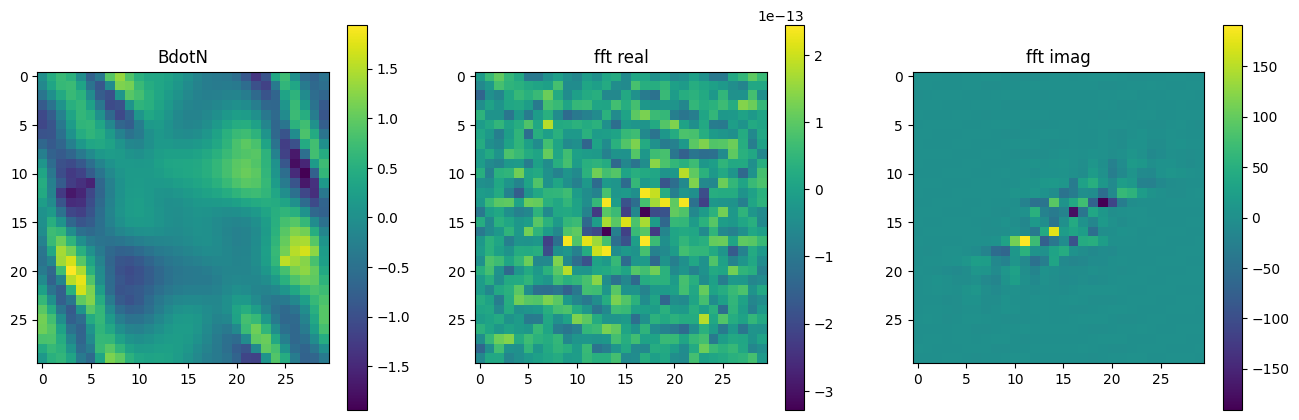

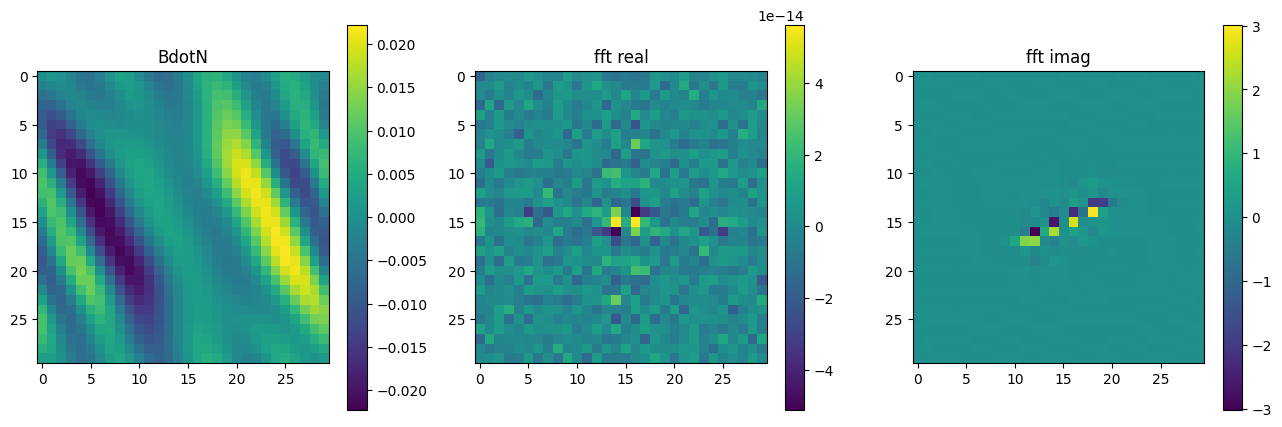

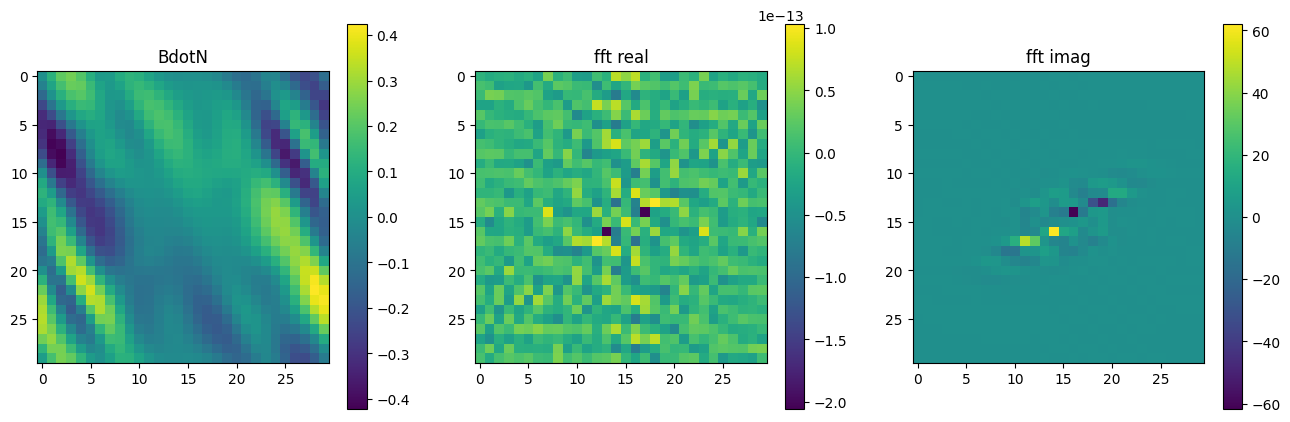

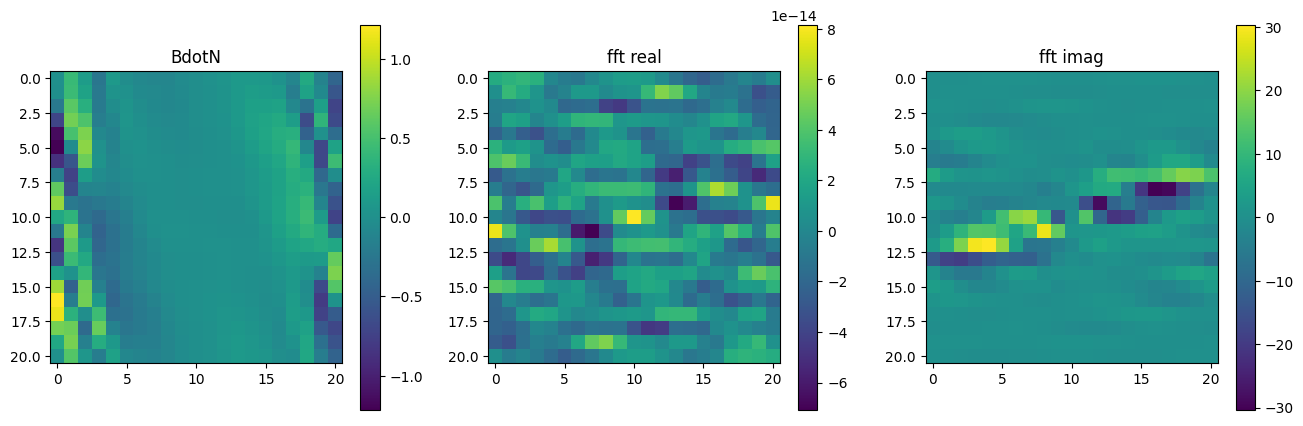

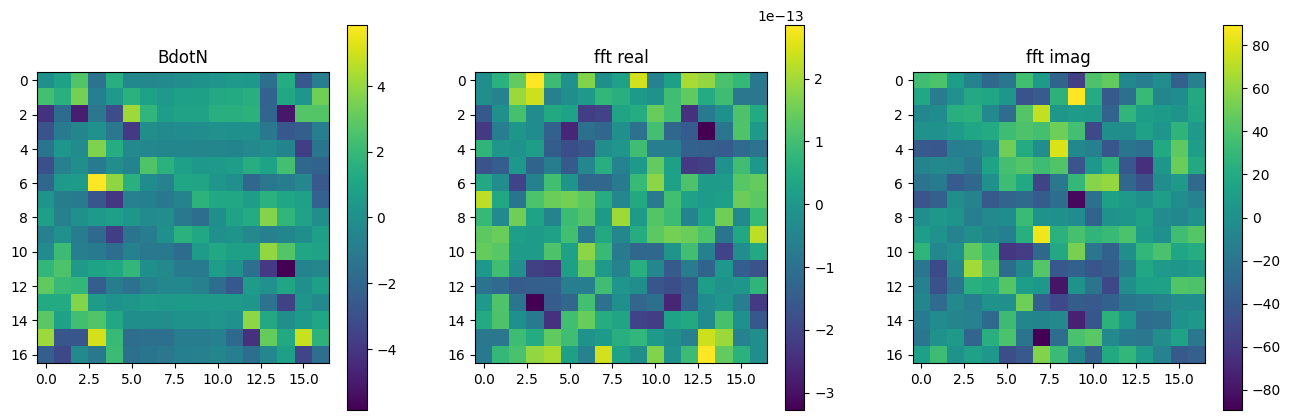

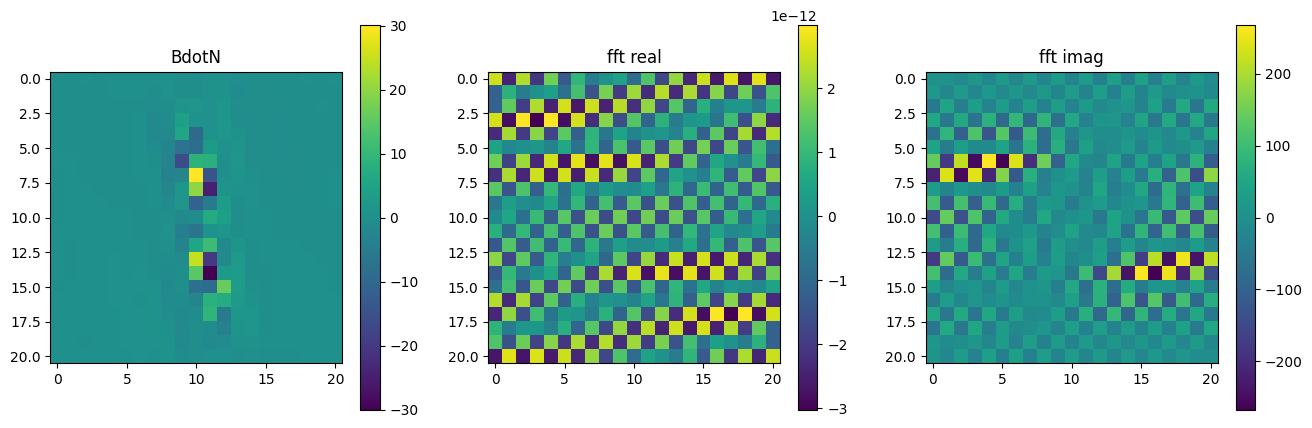

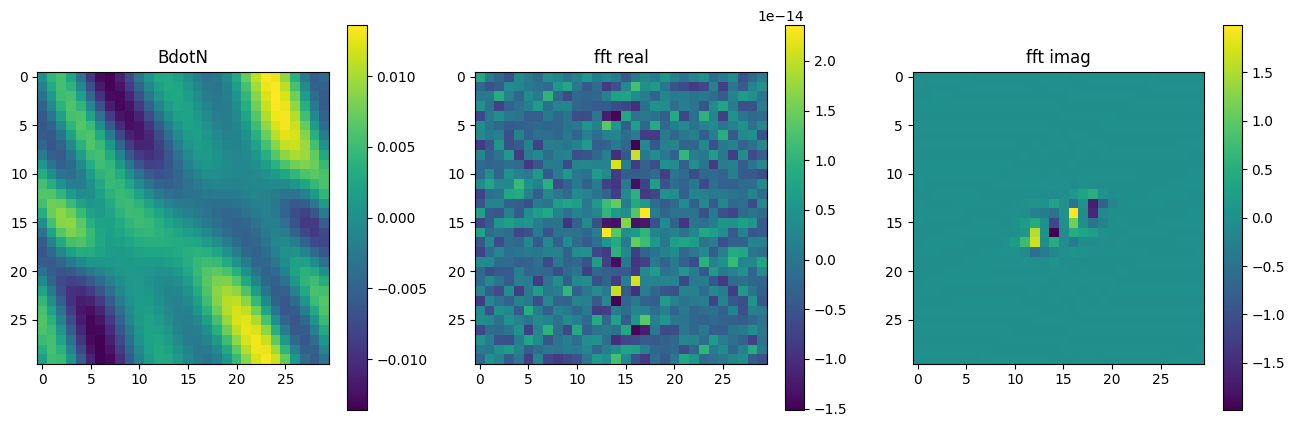

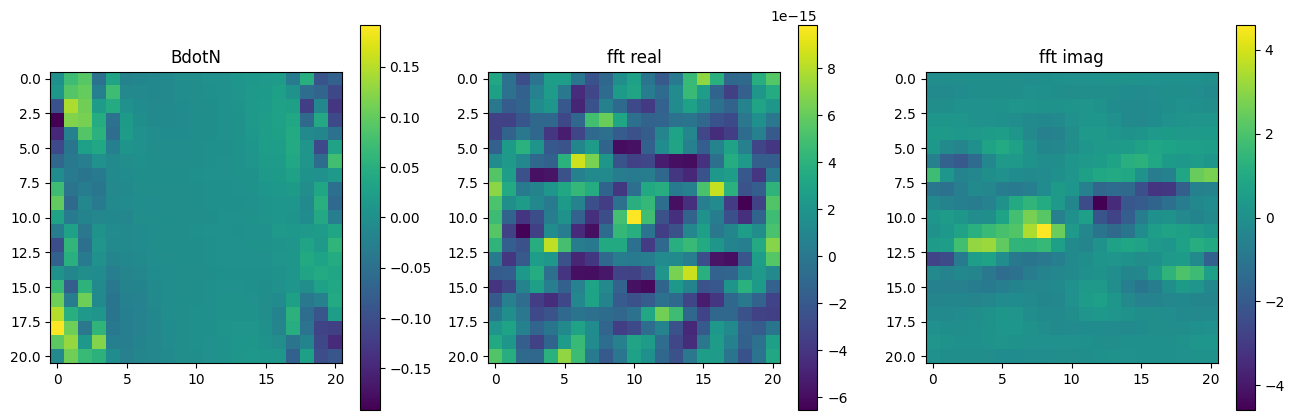

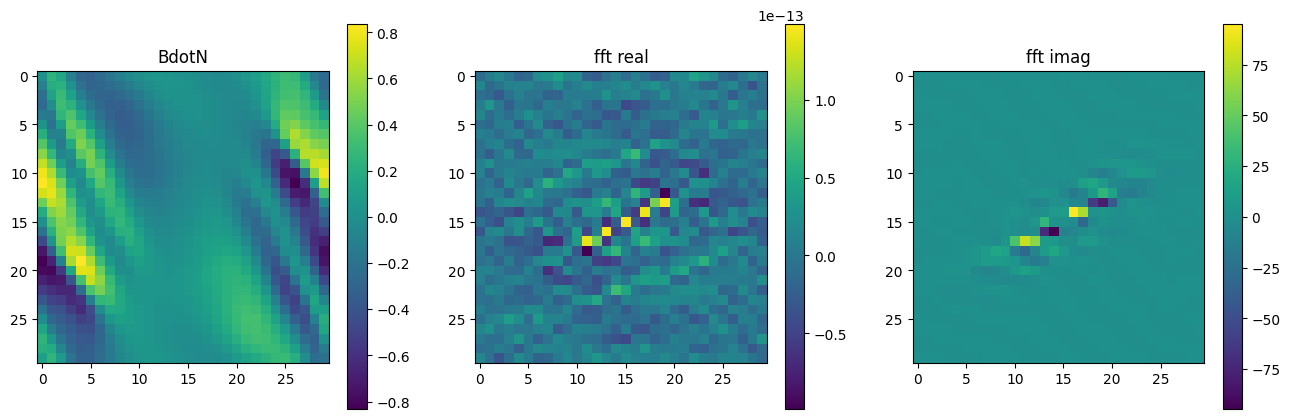

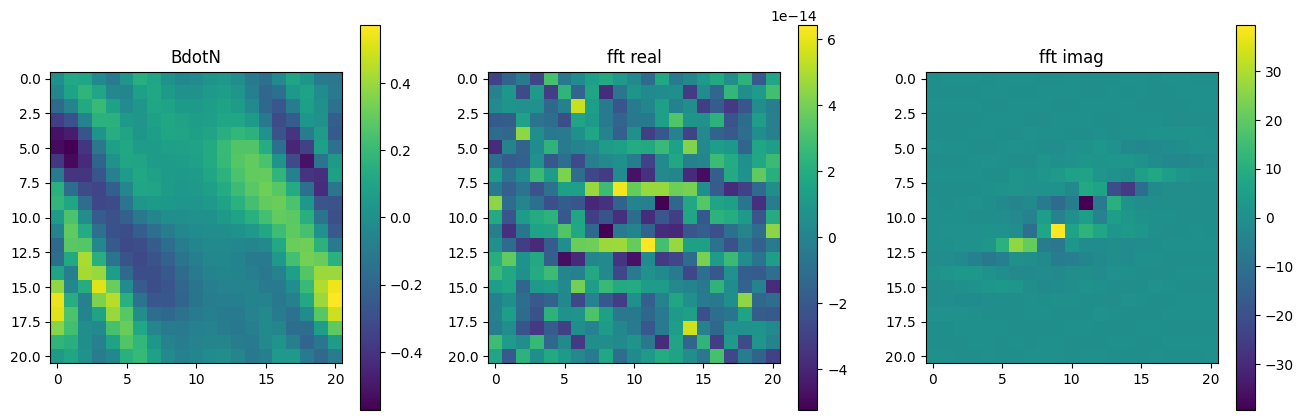

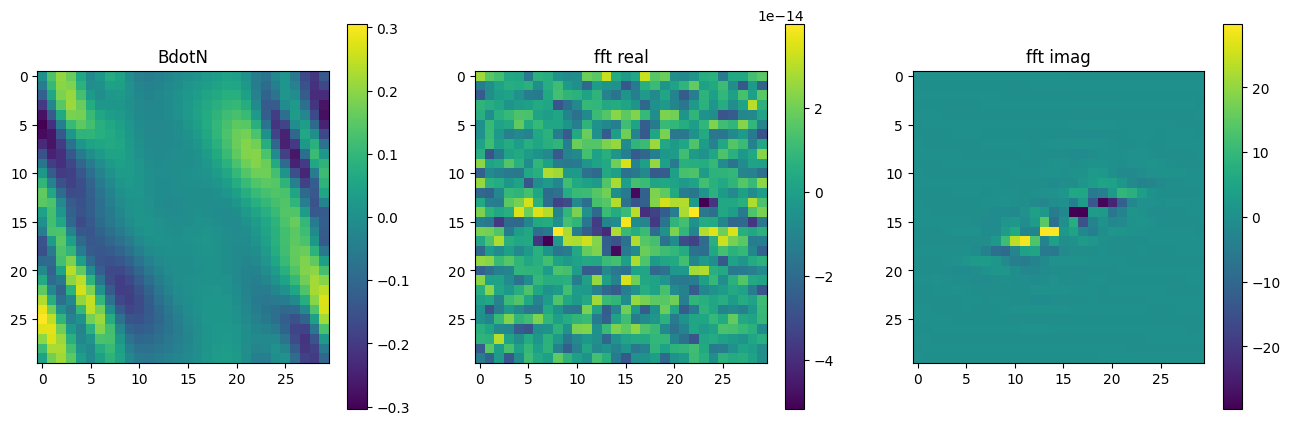

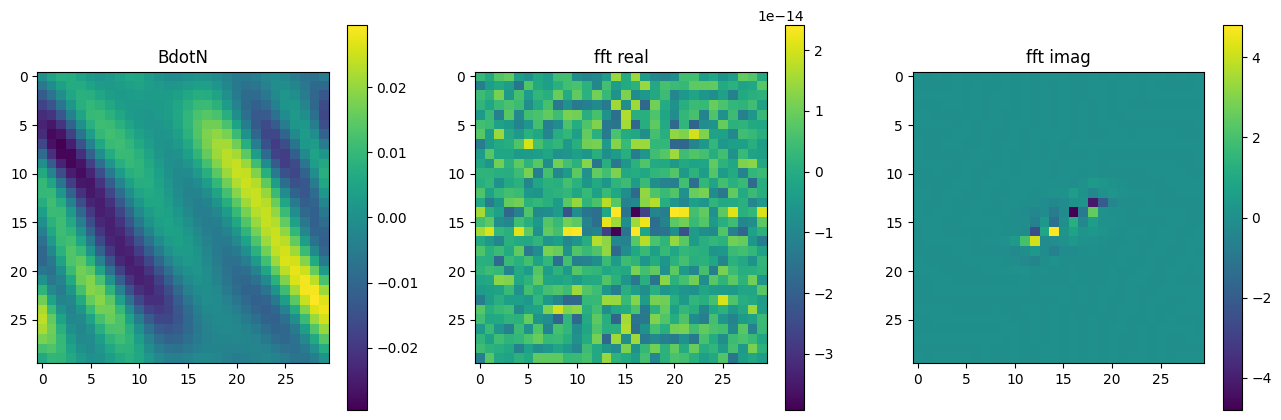

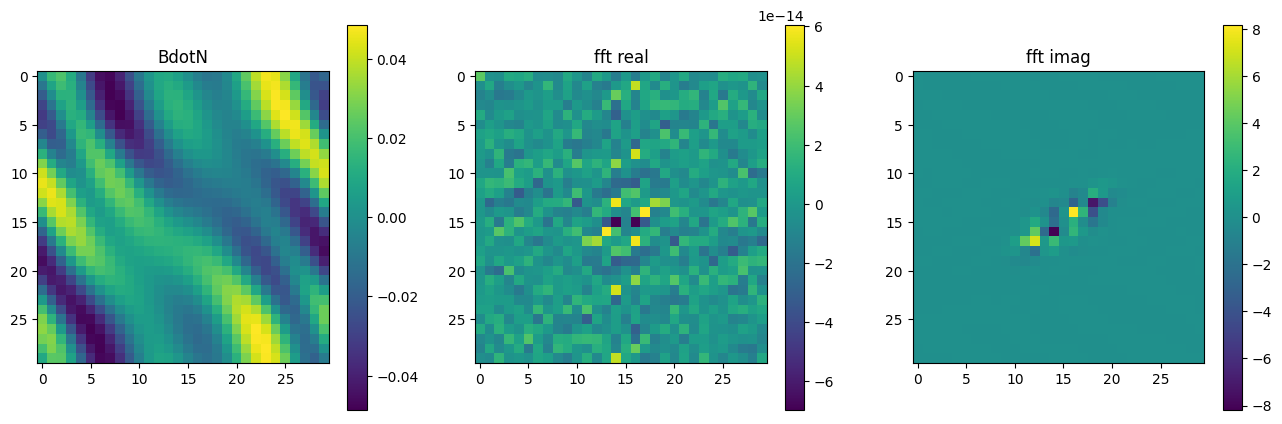

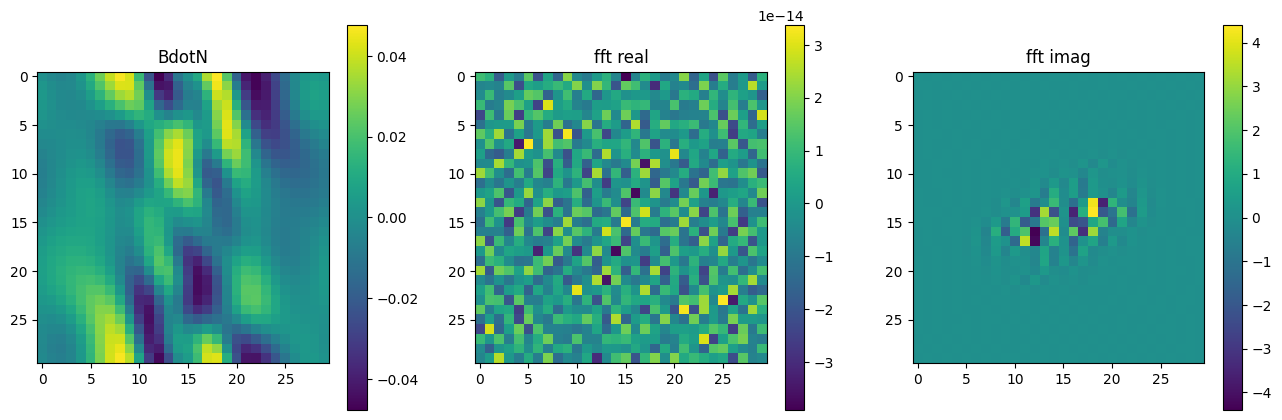

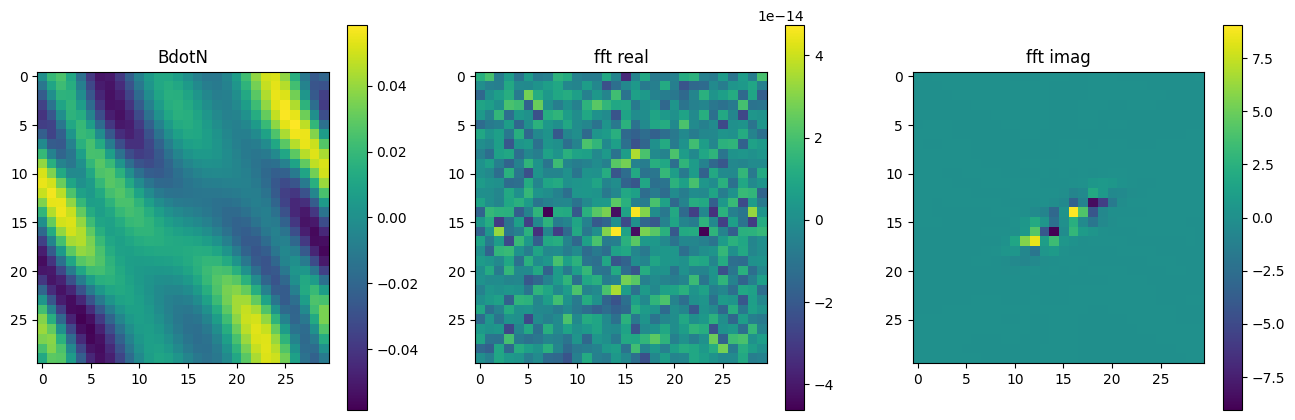

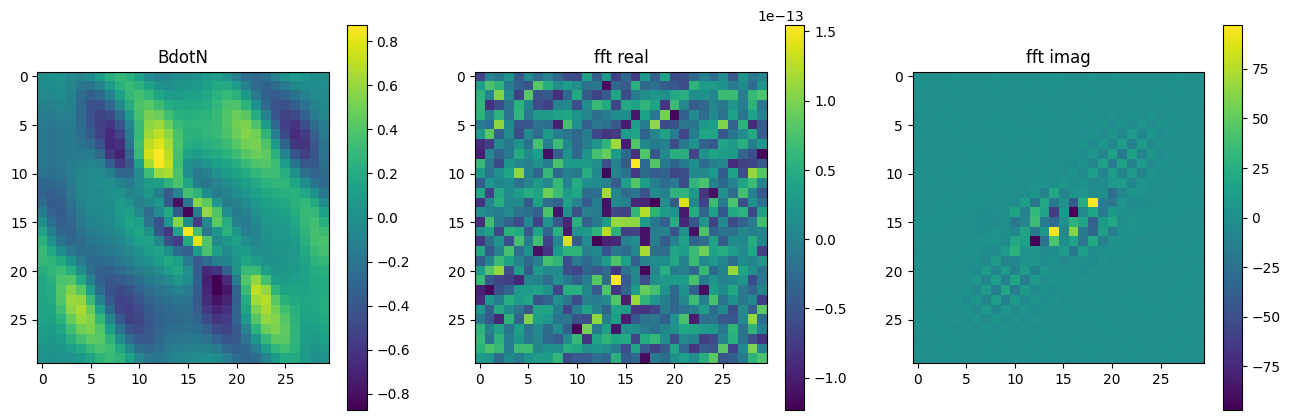

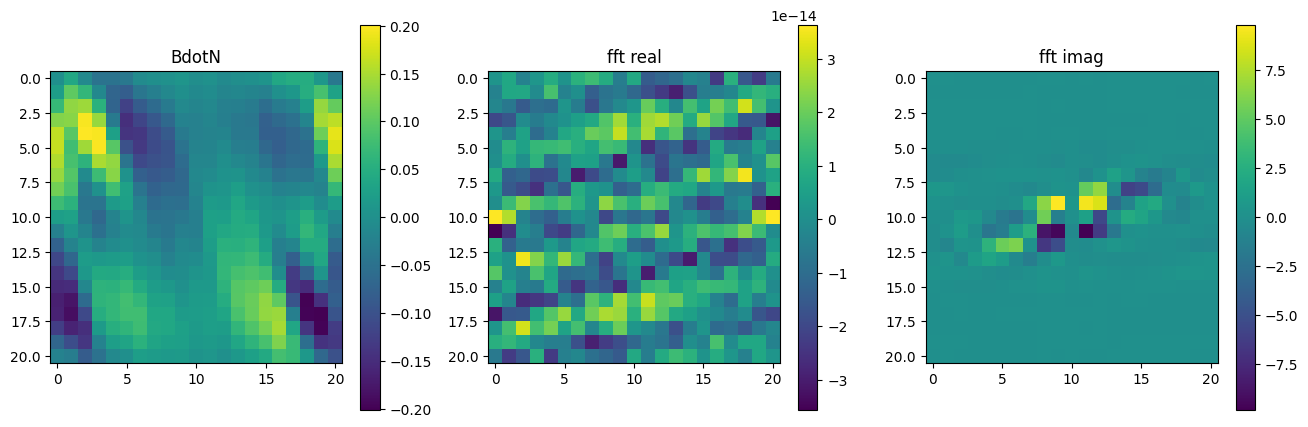

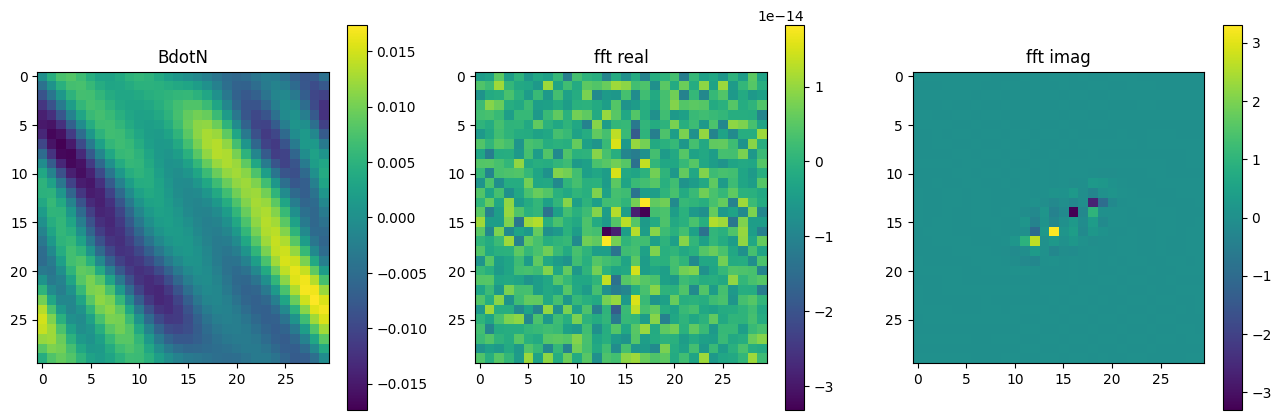

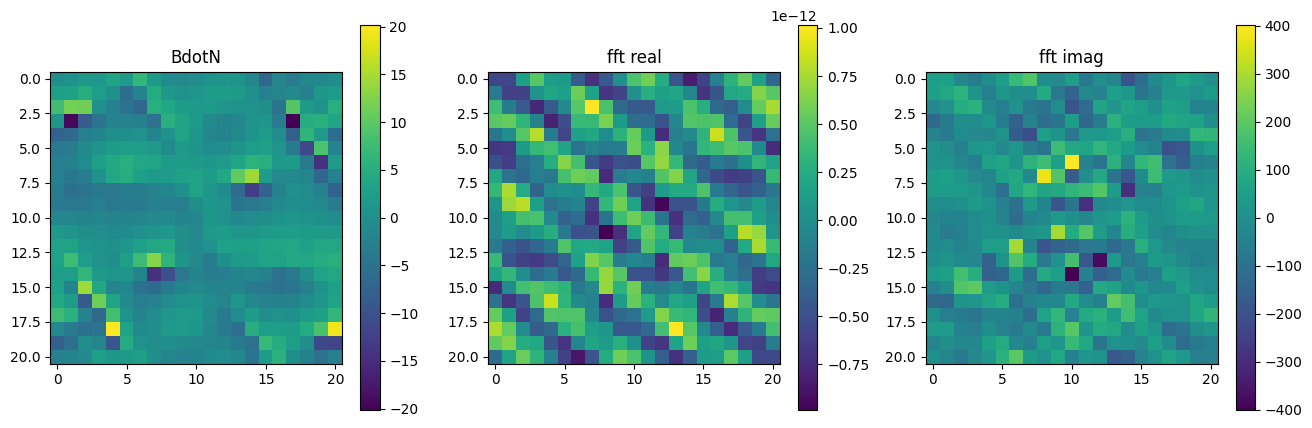

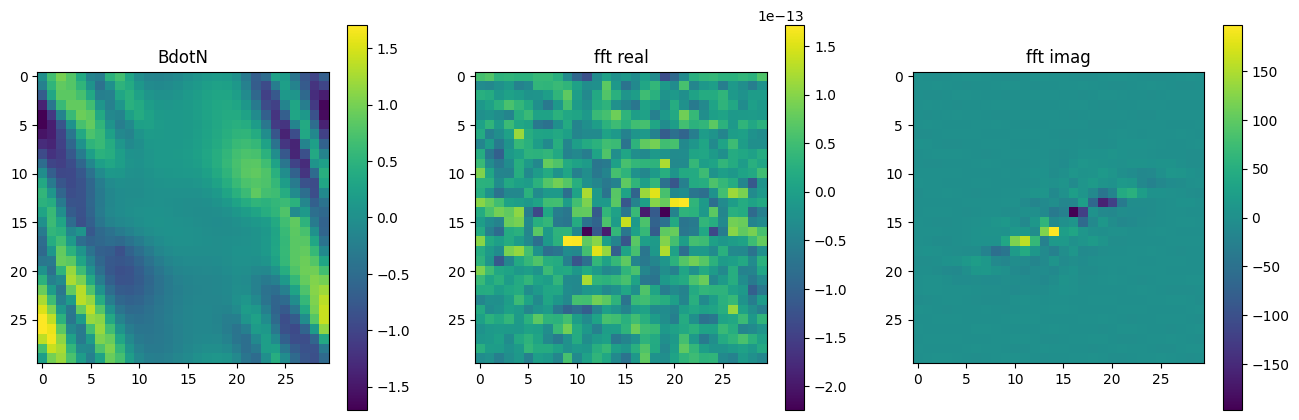

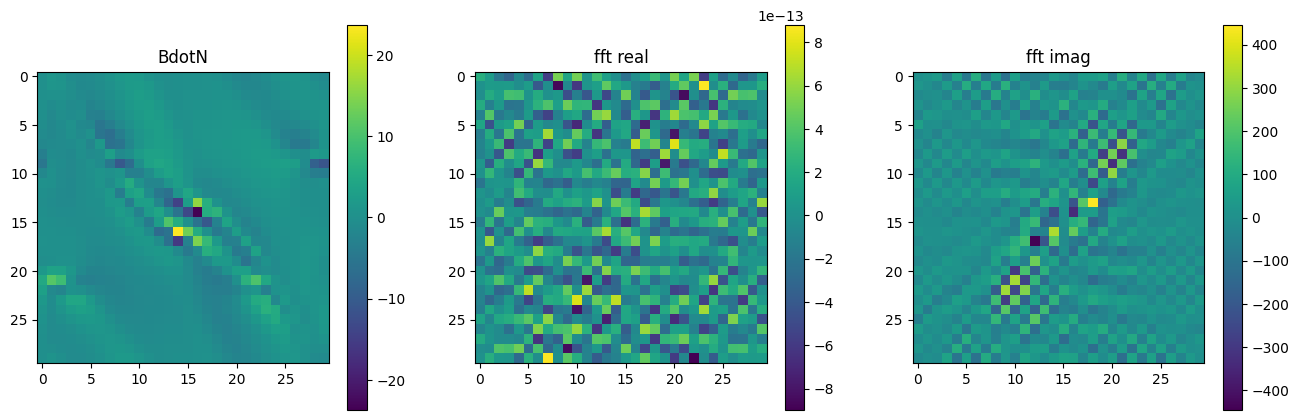

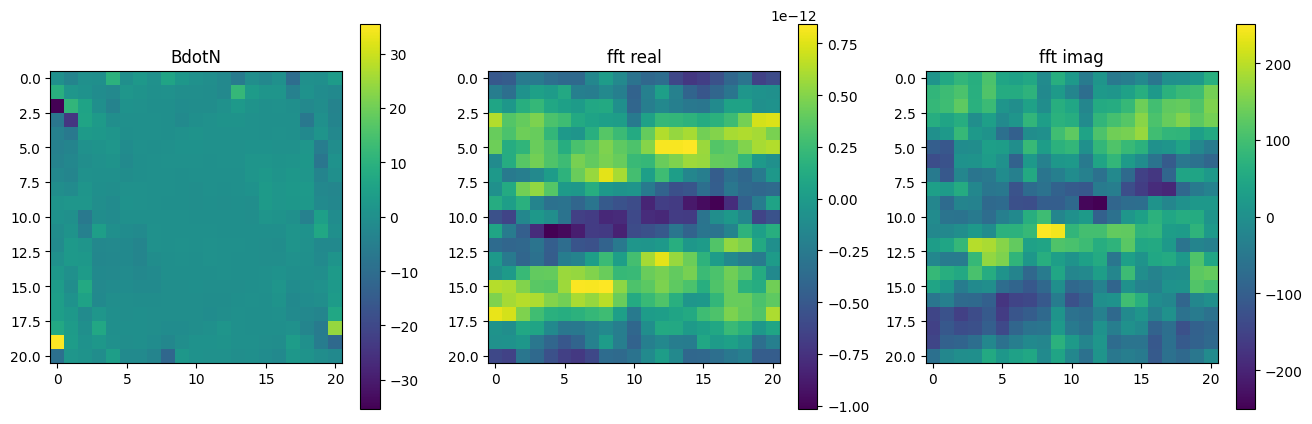

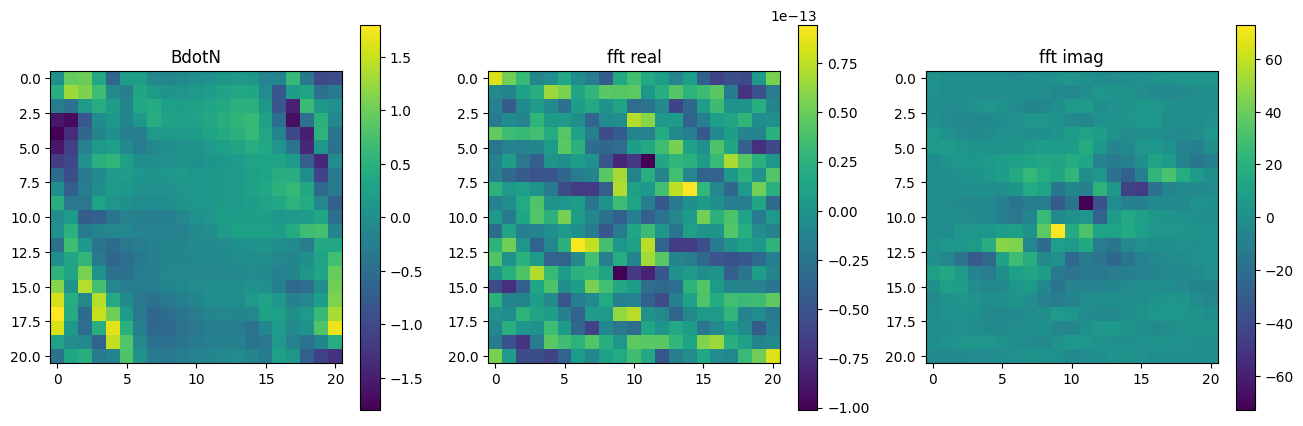

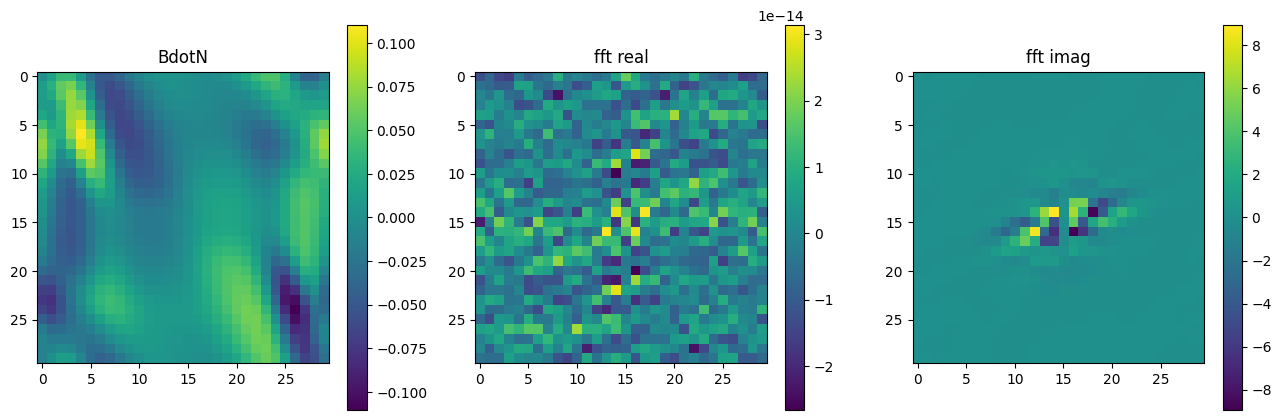

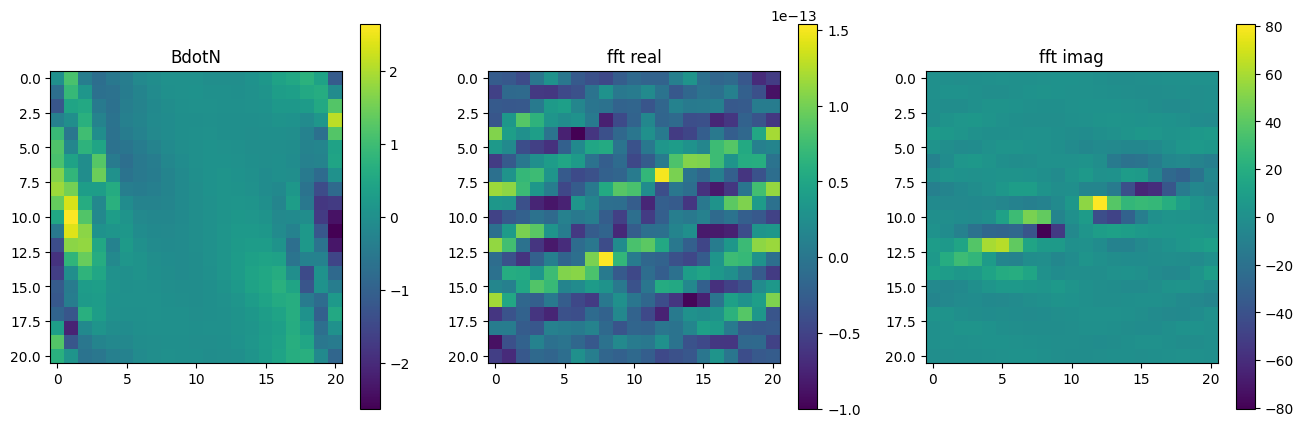

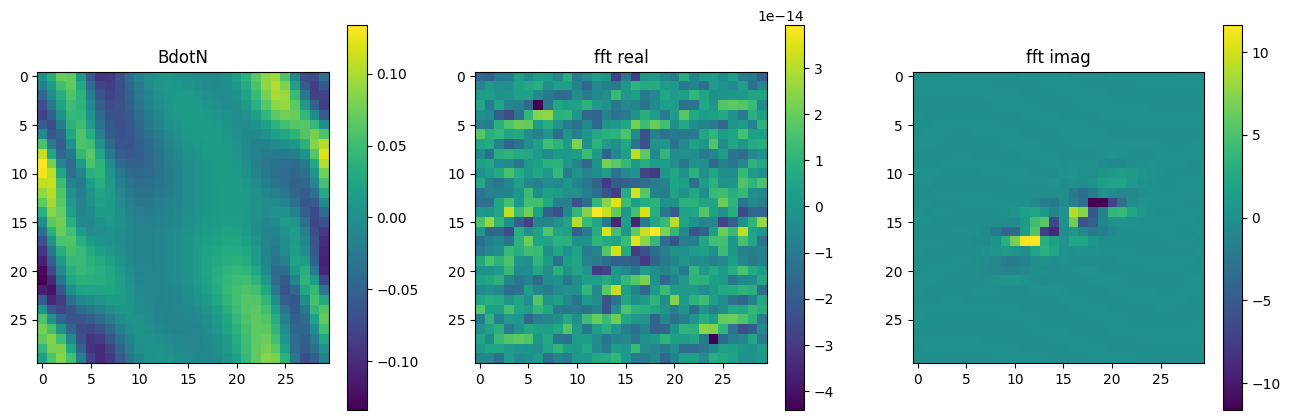

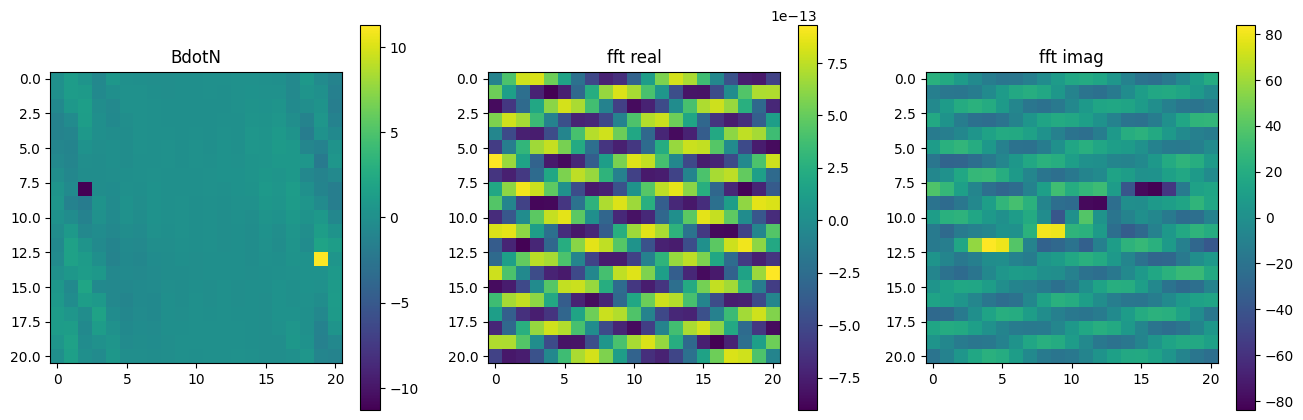

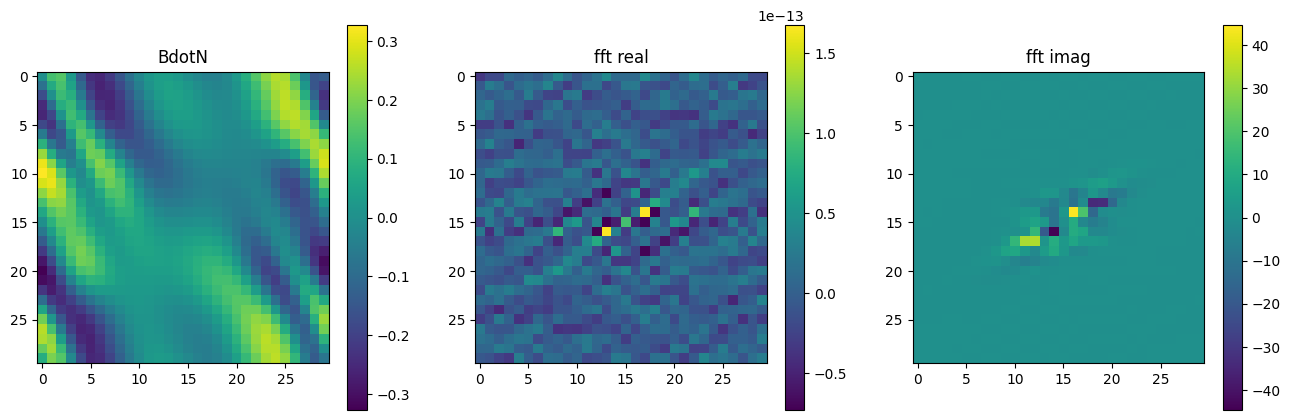

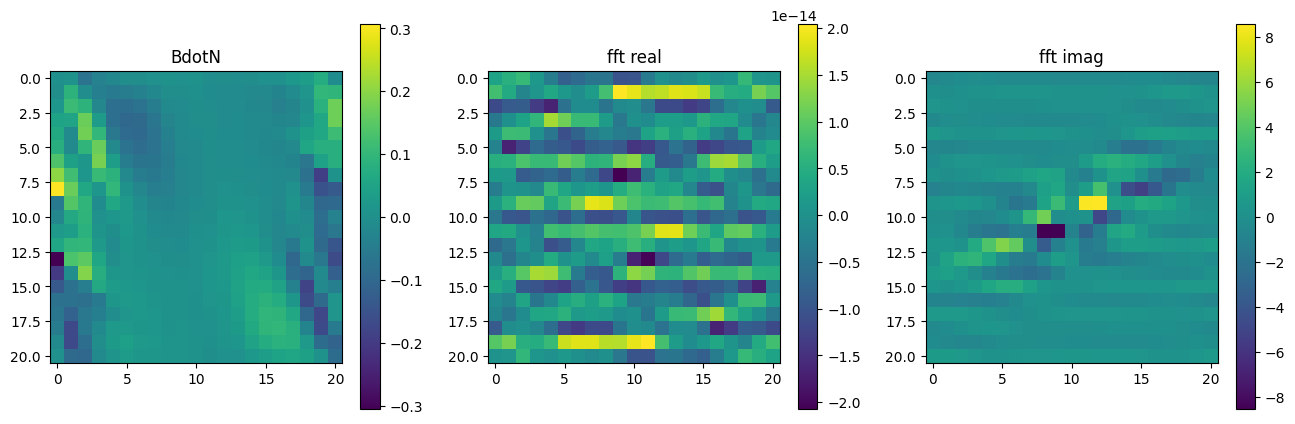

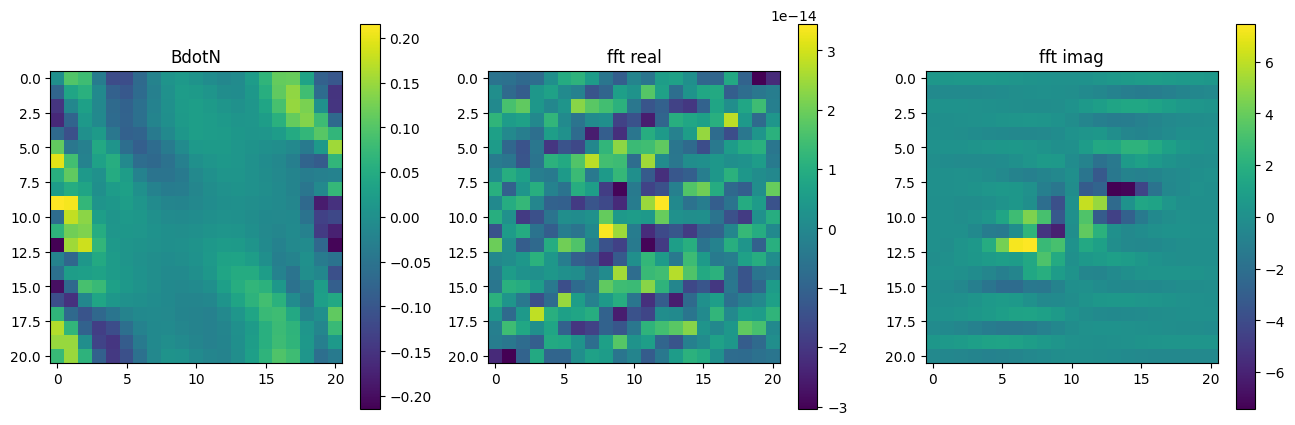

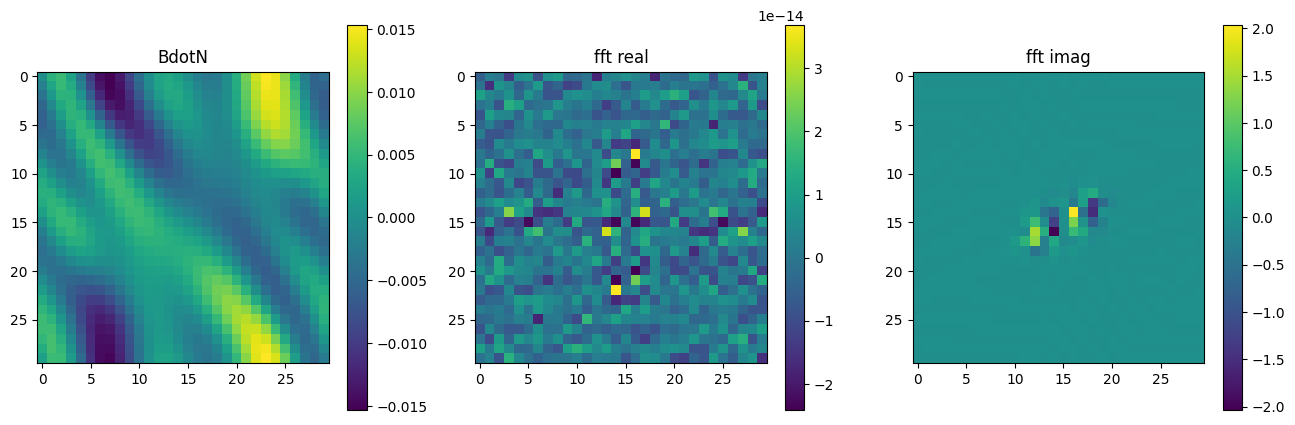

In [94]:
def eval_row(row, plot=False):
  coils = row["coils"]
  nfp = row["nfp"]
  R1 = row["R1"]
  lcfs = row["lcfs"]
  computational_surface = simsopt.geo.SurfaceRZFourier.from_nphi_ntheta(nfp=nfp, nphi=64, ntheta=64, range="field period")

  # Simple torus boundary
  computational_surface.set_rc(1,0,R1*2.0)
  computational_surface.set_zs(1,0,R1*2.0)
  computational_surface.change_resolution(3,4)
  # computational_surface.set_rc(2,1,np.random.rand())
  # computational_surface.set_zs(1,2,np.random.rand())
  normal_computational = computational_surface.normal()
  xyz_computational = computational_surface.gamma()

  # Scaled computational boundary
  scale = 1.5
  lcfs.scale(scale)
  xyz_computational = lcfs.gamma()
  normal_computational = lcfs.normal()
  lcfs.scale(1.0 / scale)

  bs = simsopt.field.BiotSavart(coils)
  bs.set_points_cart(xyz_computational.reshape((-1,3)))
  B = bs.B().reshape(xyz_computational.shape)
  BdotN = np.sum(normal_computational * B, axis=-1)
  BdotN_fft = np.fft.fft2(BdotN)
  
  if plot:
    import plotly.express as px
    # px.imshow(BdotN).show()
    # px.imshow(np.abs(np.fft.fftshift(BdotN_fft))).show()
    # px.imshow(np.real(np.fft.fftshift(BdotN_fft)), title="Real component").show()
    # px.imshow(np.imag(np.fft.fftshift(BdotN_fft)), title="Imag component").show()
    plt.figure(figsize=(16,5))
    plt.subplot(131)
    plt.imshow(BdotN)
    plt.title("BdotN")
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(np.real(np.fft.fftshift(BdotN_fft)))
    plt.title("fft real")
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(np.imag(np.fft.fftshift(BdotN_fft)))
    plt.title("fft imag")
    plt.colorbar()
    # plt.tight_layout()
    plt.show()

  return BdotN_fft

for idx,row in df.iterrows():
  eval_row(row, True)

- Check simple computational boundaries
- Check using a simple scaled up boundary
- Is SVD independent of boundary geometry?

In [46]:
import plotly.express as px
import plotly.graph_objects as go

go.Figure([
  go.Surface(x=xyz_computational[:,:,0], y=xyz_computational[:,:,1], z=xyz_computational[:,:,2], surfacecolor=BdotN)
])